## Import Necessary Modules

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import ddpg_agent_wandb as ddpg_agent
from ddpg_agent_wandb import Agent as Agency
from ddpg_agent_wandb import SEED, BUFFER_SIZE, BATCH_SIZE, device
print("Using device:", device)
%matplotlib inline

Using device: cuda:0


## Unity Reacher Environment

In [4]:
R20execfile = '../UnityReacher20/Reacher.exe'
R1execfile = "../../data/Reacher1_Win/Reacher.exe"

env = UnityEnvironment(file_name=R20execfile, worker_id=20, seed=SEED, no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Examine the State and Action Spaces

In [5]:

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length {} and returns an action with length {}'.format(states.shape[0], state_size, action_size))
#print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length 33 and returns an action with length 4


## DDPG

#### Intialize the Agent

In [6]:
agency = Agency(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=SEED)    #,
                #actor_filename=None, critic_filename=None)

#### Random Agent Play

In [6]:
if False:
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
    rap_states = env_info.vector_observations                  # get the current state (for each agent)
    rap_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
    #    rap_actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #    rap_actions = np.clip(rap_actions, -1, 1)                  # all actions between -1 and 1
        rap_actions = agency.act(rap_states, add_noise=True)
        env_info = env.step(rap_actions)[brain_name]           # send all actions to tne environment
        rap_next_states = env_info.vector_observations         # get next state (for each agent)
        rap_rewards = env_info.rewards                         # get reward (for each agent)
        rap_dones = env_info.local_done                        # see if episode finished
        rap_scores += env_info.rewards                         # update the score (for each agent)
        rap_states = rap_next_states                               # roll over states to next time step
        if np.any(rap_dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(rap_scores)))

#### Train

In [7]:
def ddpg(n_episodes=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    agent_scores = []
    for i_episode in (range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agency.reset()
        score = 0.
        individual_scores = np.zeros(num_agents)
        while True:
            action = agency.act(state)
            #action, noise = agency.act(state, return_noise=True)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agency.step(state, action, reward, next_state, done)
            state = next_state
            score += np.mean(reward)
            individual_scores += reward
            if np.any(done):
                break 
        scores_deque.append(score)
        scores.append(score)
        agent_scores.append(individual_scores)
        cycle_steps = agency.steps%ddpg_agent.BUFFER_SIZE
        buffer_cycle = agency.steps//ddpg_agent.BUFFER_SIZE
        
        print('\rEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode, 
                                                                                                                score, 
                                                                                                                np.mean(scores_deque),
                                                                                                                buffer_cycle,
                                                                                                                cycle_steps), end="")
        
        if i_episode % 10 == 0:
            chkpntname = "artifacts/actor_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agency.actor_local.state_dict(), chkpntname)  
            chkpntname = "artifacts/critic_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agency.critic_local.state_dict(), chkpntname) 
            print('\rEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode,
                                                                                                                    score,
                                                                                                                    np.mean(scores_deque),
                                                                                                                    buffer_cycle,
                                                                                                                    cycle_steps))
        
        #if sum( np.array(scores_deque)>=30 ) >= 100:
        if np.mean(scores_deque)>=30:
            print('\nAvg. rewards have been stabily above the metric for 100 episodes.\nEnvironment officially solved at episode {:d}!\tAverage Reward: {:6.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agency.actor_local.state_dict(), 'artifacts/slvdpnt_actor.pth')
            torch.save(agency.critic_local.state_dict(), 'artifacts/slvdpnt_critic.pth')
            break

    torch.save(agency.actor_local.state_dict(), "artifacts/actor_trained.pth")
    torch.save(agency.critic_local.state_dict(), "artifacts/critic_trained.pth") 
    print('\nFINAL\nEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode,
                                                                                                                    score,
                                                                                                                    np.mean(scores_deque),
                                                                                                                    buffer_cycle,
                                                                                                                    cycle_steps))
    return scores, agent_scores

In [8]:
### TRAIN AGENTS
sc, ag = ddpg()
try:
    scores+=sc
    agent_scores+=ag 
except:
    scores=sc
    agent_scores=ag


Episode   10	Reward:   0.49	Average Reward:   0.32	Buffer Cycle:  0 mod 200200
Episode   20	Reward:   3.00	Average Reward:   0.89	Buffer Cycle:  0 mod 400400
Episode   30	Reward:   8.11	Average Reward:   2.20	Buffer Cycle:  1 mod  88600
Episode   40	Reward:  11.65	Average Reward:   4.22	Buffer Cycle:  1 mod 288800
Episode   50	Reward:  22.58	Average Reward:   7.07	Buffer Cycle:  1 mod 489000
Episode   60	Reward:  29.35	Average Reward:  10.36	Buffer Cycle:  2 mod 177200
Episode   70	Reward:  35.63	Average Reward:  13.63	Buffer Cycle:  2 mod 377400
Episode   80	Reward:  36.62	Average Reward:  16.45	Buffer Cycle:  3 mod  65600
Episode   90	Reward:  37.94	Average Reward:  18.74	Buffer Cycle:  3 mod 265800
Episode  100	Reward:  38.13	Average Reward:  20.63	Buffer Cycle:  3 mod 466000
Episode  110	Reward:  36.59	Average Reward:  24.28	Buffer Cycle:  4 mod 154200
Episode  120	Reward:  36.86	Average Reward:  27.82	Buffer Cycle:  4 mod 354400
Episode  127	Reward:  35.40	Average Reward:  30.10	B

##### Restart

In [ ]:
torch.save(agency.actor_local.state_dict(), 'artifacts/trained_actor.pth')
torch.save(agency.critic_local.state_dict(), 'artifacts/trained_critic.pth')

In [13]:
try: 
    env.close()
    print("Closed the active environment.")
except:
    print("No active environment detected.")

No active environment detected.


#### Results

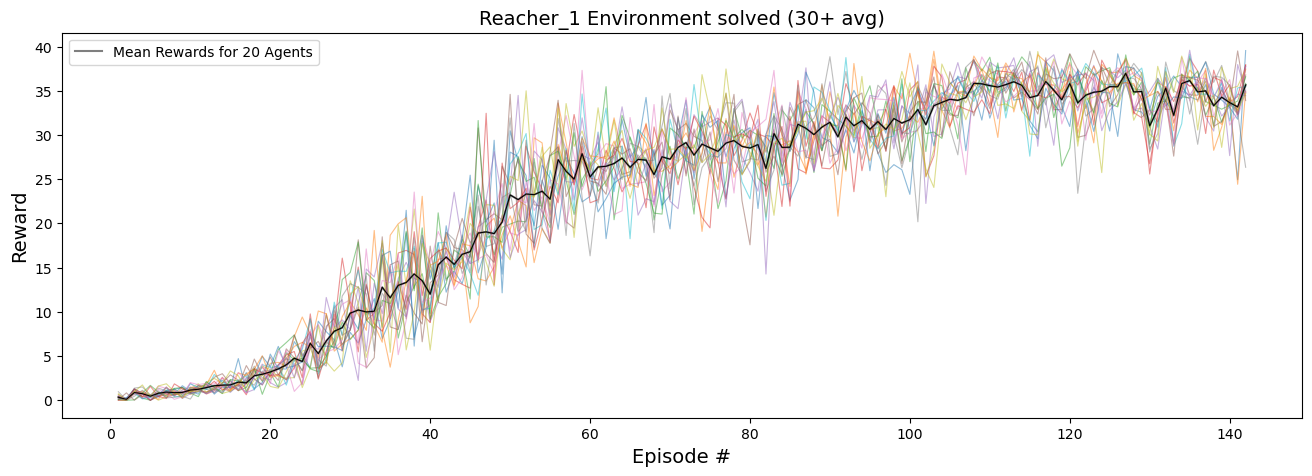

In [11]:
## Learning Curve
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(np.arange(1, len(scores)+1), scores, c='#000', alpha=0.5, linewidth=1.5, label='Mean Rewards for 20 Agents')
for i in range(1,20):
    ax.plot(np.arange(1, len(agent_scores)+1), [s[i] for s in agent_scores], alpha=0.5, linewidth=0.8)
ax.plot(np.arange(1, len(scores)+1), scores, c='#000', alpha=1.0, linewidth=0.75)
plt.legend()
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Reward', fontsize=14)
ax.set_title('Reacher_20 Environment solved (30+ avg)', fontsize=14)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(np.arange(1, len(scores)+1), scores, color='r', label='Mean Reward across 20 Agents')
for i in range(20):
    ax.plot(np.arange(1, len(scores)+1), [s[i] for s in agent_scores], alpha=0.1)
plt.legend()
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Reward', fontsize=14)
ax.set_title('Unity Reacher Environment using DDPG', fontsize=16)
plt.show()

In [ ]:
### Run some test runs...
for _ in range(1):    
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   
    tr_states = env_info.vector_observations                  # get the current state (for each agent)
    tr_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        tr_actions = agency.act(tr_states, add_noise=False)       # select an action (for each agent)
        env_info = env.step(tr_actions)[brain_name]           # send all actions to tne environment
        tr_next_states = env_info.vector_observations         # get next state (for each agent)
        tr_rewards = env_info.rewards                         # get reward (for each agent)
        tr_dones = env_info.local_done                        # see if episode finished
        tr_scores += env_info.rewards                         # update the score (for each agent)
        tr_states = tr_next_states                               # roll over states to next time step
        if np.any(tr_dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(tr_scores)))

#env.close()

In [ ]:
agent_scores, scores

When finished, you can close the environment.

In [ ]:
env.close()

#### Evaluation

In [ ]:
### Close and Restart
try: 
    print("Closing the active environment.")
    env.close()
except:
    print("No active environment detected.")

# WANDB

In [ ]:
run_config={
    "actor": "Actor",
    "critic": "CriticW"
    "BUFFER_SIZE": int(2.56e5),
    "BATCH_SIZE":128,
    "GAMMA":GAMMA,
    "TAU":TAU,
    "LR_ACTOR":1e-4,
    "LR_CRITIC":1e-4 ,
    "WEIGHT_DECAY":1e-9,}
    #"state_size":state_size, 
    #"action_size":action_size,}

In [12]:
try: 
    env.close()
    print("Closed the active environment.")
except:
    print("No active environment to close.")

Closed the active environment.


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import ddpg_agent_wandb as ddpg_agent
from ddpg_agent_wandb import Agent as Agency
from ddpg_agent_wandb import SEED, BUFFER_SIZE, BATCH_SIZE, device
print("Using device:", device)
%matplotlib inline

# Import the W&B Python Library 
import wandb

R20execfile = '../UnityReacher20/Reacher.exe'
R1execfile = "../../data/Reacher1_Win/Reacher.exe"
print("Using Reacher1 execfile.")
env = UnityEnvironment(file_name=R1execfile, worker_id=111, seed=SEED)#, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length {} and returns an action with length {}'.format(states.shape[0], state_size, action_size))
#print('The state for the first agent looks like:', states[0])



Using device: cuda:0
Using Reacher1 execfile.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length 33 and returns an action with length 4


In [2]:
### Train Routine with WandB Logging

def wandb_ddpg_train(n_episodes=100):
    ''' For Training at WandB
    '''

    scores_deque = deque(maxlen=100)
    scores = []; agent_scores = []
    actor_loss = []; critic_loss = []
    
    for i_episode in (range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agency.reset()
        score = 0.
        episteps=0
        individual_scores = np.zeros(num_agents)
        act_loss=0; crit_loss=0; al=None
        
        while True:
            episteps+=1
            action = agency.act(state)   # , noise = agency.act(state, return_noise=True)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            al, cl = agency.step(state, action, reward, next_state, done, return_loss=True)
            if al is not None:
                act_loss+=al; crit_loss+=cl; 
            state = next_state
            score += np.mean(reward)
            individual_scores += reward
            if np.any(done):
                break 
        scores_deque.append(score)
        scores.append(score)
        agent_scores.append(individual_scores)
        actor_loss.append(act_loss/episteps)
        critic_loss.append(crit_loss/episteps)
        cycle_steps = agency.steps%ddpg_agent.BUFFER_SIZE
        buffer_cycle = agency.steps//ddpg_agent.BUFFER_SIZE    
        
        # log metrics to wandb
        wandb.log({ #"episode":i_episode,
                    "episode_scores":score,
                    #"agent_scores":individual_scores,
                    "actor_loss":act_loss/episteps,
                    "critic_loss":crit_loss/episteps,})

        print('\rEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tActor Loss: {:7.3f}\tCritic Loss: {:7.3f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode, 
                                score, 
                                np.mean(scores_deque),
                                actor_loss[-1],
                                critic_loss[-1],
                                buffer_cycle,
                                cycle_steps), end="")

        if i_episode % 10 == 0:
            chkpntname = "artifacts/actor_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agency.actor_local.state_dict(), chkpntname)  
            chkpntname = "artifacts/critic_training_chkpnt{:d}.pth".format(i_episode)
            torch.save(agency.critic_local.state_dict(), chkpntname) 
            print('\rEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tActor Loss: {:7.3f}\tCritic Loss: {:7.3f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode,
                                score,
                                np.mean(scores_deque),
                                actor_loss[-1],
                                critic_loss[-1],
                                buffer_cycle,
                                cycle_steps))
        
        if np.mean(scores_deque)>30:
            print('\nAvg. rewards have been stabily above 30 for 100 episodes.\nEnvironment officially solved at episode {:d}!\tAverage Reward: {:6.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agency.actor_local.state_dict(), 'artifacts/slvdpnt_actor.pth')
            torch.save(agency.critic_local.state_dict(), 'artifacts/slvdpnt_critic.pth')
            break

    torch.save(agency.actor_local.state_dict(), "artifacts/actor_trained.pth")
    torch.save(agency.critic_local.state_dict(), "artifacts/critic_trained.pth") 
    print('\nFINAL\nEpisode{:5d}\tReward: {:6.2f}\tAverage Reward: {:6.2f}\tBuffer Cycle: {:2d} mod {:6d}'.format(i_episode,
                                score,
                                np.mean(scores_deque),
                                buffer_cycle,
                                cycle_steps))
    
    return scores, agent_scores, actor_loss, critic_loss

#### Train 1

In [3]:
### One Agent  ###

agency = Agency(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=SEED, 
                mu=ddpg_agent.MU, theta=ddpg_agent.THETA, sigma=ddpg_agent.SIGMA,)
                actor_filename="artifacts/actor_in_training.pth", critic_filename="artifacts/critic_in_training.pth")

scores, agent_scores, actor_loss, critic_loss = (0,0,0,0)

In [6]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations
agency.reset()
score = 0.
episteps=0
act_loss=0; crit_loss=0; al=None

episteps+=1
action = agency.act(state)   # , noise = agency.act(state, return_noise=True)
env_info = env.step(action)[brain_name]
next_state = env_info.vector_observations
reward = env_info.rewards
done = env_info.local_done
al, cl = agency.step(state, action, reward, next_state, done, return_loss=True)
cl

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = 0                                             # initialize the score (for each agent)
#img=plt.imshow(  )
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    scores += rewards[0]                               # update the score (for each agent)
    dones = env_info.local_done                        # see if episode finished
    states = next_states                               # roll over states to next time step
    #imgdata = np.hstack([scalenp(rewards).reshape(12,1), actions])
    #img.set_data(imgdata.T) 
    #plt.axis('off')
    #title = "{:4d} | {:5d} | {:7.2f} | {:2.2f} {:2.2f}".format(chkpnt, j+1, score, action[0], action[1])
    #plt.title(str(i))
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    if np.any(dones):                                  # exit loop if episode finished
    break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


In [7]:
run_config={
    "actor": "Actor",
    "critic": "CriticW",
    "GAMMA":ddpg_agent.GAMMA,
    "TAU":ddpg_agent.TAU,
    "LR_ACTOR":1e-4,
    "LR_CRITIC":1e-4 ,
    "WEIGHT_DECAY":1e-9,
    "BUFFER_SIZE": ddpg_agent.BUFFER_SIZE,
    "BATCH_SIZE": ddpg_agent.BATCH_SIZE,
    "noise_mu":ddpg_agent.MU,
    "noise_theta":ddpg_agent.THETA,
    "noise_sigma":ddpg_agent.SIGMA,}


Error: You must call wandb.init() before wandb.config.noise_mu

In [10]:
### TRAIN SINGLE AGENT
# start a new wandb run to track this script
training_run = wandb.init(
                            # set the wandb project where this run will be logged
                            project="reacher v1",
                            # hyperparameters to track, metadata to run
                            config=run_config
                         )

sc, ag, al, cl = wandb_ddpg_train(300)

wandb.finish()

try:
    scores+=sc
    agent_scores+=ag 
    actor_loss+=al
    critic_loss+=cl
except:
    scores=sc
    agent_scores=ag
    actor_loss=al
    critic_loss=cl

Episode   10	Reward:  36.79	Average Reward:  24.69	Actor Loss:  -3.716	Critic Loss:   0.015	Buffer Cycle:  2 mod  98613
Episode   20	Reward:  34.75	Average Reward:  28.43	Actor Loss:  -3.788	Critic Loss:   0.014	Buffer Cycle:  2 mod 108623
Episode   30	Reward:  35.39	Average Reward:  27.83	Actor Loss:  -3.843	Critic Loss:   0.017	Buffer Cycle:  2 mod 118633
Episode   40	Reward:   9.87	Average Reward:  25.94	Actor Loss:  -3.877	Critic Loss:   0.015	Buffer Cycle:  2 mod 128643
Episode   50	Reward:  30.69	Average Reward:  25.30	Actor Loss:  -3.907	Critic Loss:   0.017	Buffer Cycle:  2 mod 138653
Episode   60	Reward:  31.34	Average Reward:  24.96	Actor Loss:  -3.948	Critic Loss:   0.017	Buffer Cycle:  2 mod 148663
Episode   70	Reward:  31.19	Average Reward:  25.44	Actor Loss:  -4.006	Critic Loss:   0.018	Buffer Cycle:  2 mod 158673
Episode   80	Reward:  26.15	Average Reward:  25.50	Actor Loss:  -4.069	Critic Loss:   0.018	Buffer Cycle:  2 mod 168683
Episode   90	Reward:  19.15	Average Rewa

actor_loss,████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁
critic_loss,▂▂▂▁▂▂▄▃▂▅▅▄▄▃▄▆▆▅▅▄▆▅▃▆▆▇▆█▆▇█▆▅▆▆██▇██
episode_scores,▅▇█▇▇▅█▇▇▁▅▂▃▅▇▅▆▅▅▄▆▅▇▆▆▆▆▇▄▆▇██▇█▆█▆▆▇
actor_loss,-4.58708
critic_loss,0.01822
episode_scores,35.73


#### Train 20

In [ ]:
agency = Agency(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=SEED, 
                         actor_filename='artifacts/actor_training_chkpnt50.pth', critic_filename='artifacts/critic_training_chkpnt50.pth')
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment in test mode    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agency.act(states, add_noise=False)      # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [6]:
### Agency for 20 agents ###
agency = Agency(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=SEED,
                actor_filename="artifacts/slvdpnt_actor.pth", critic_filename="artifacts/slvdpnt_critic.pth")

scores, agent_scores, actor_loss, critic_loss = (0,0,0,0)

In [18]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations
agency.reset()
action = agency.act(state)
env_info = env.step(action)[brain_name]
next_state = env_info.vector_observations
reward = env_info.rewards
done = env_info.local_done

result, r = agency.step(state, action, reward, next_state, done, return_loss=True)
result, r

(None, None)

In [ ]:
run_config={
    "actor": "Actor",
    "critic": "CriticW"
    "BUFFER_SIZE": int(2.56e5),
    "BATCH_SIZE":128,
    "GAMMA":ddpg_agent_wandb.GAMMA,
    "TAU":ddpg_agent_wandb.TAU,
    "LR_ACTOR":1e-4,
    "LR_CRITIC":1e-4 ,
    "WEIGHT_DECAY":1e-9,
    "BUFFER_SIZE": 1.28e6,
    "BATCH_SIZE": 256,
    "noise_mu":ddpg_agent_wandb.MU,
    "noise_theta":ddpg_agent_wandb.THETA,
    "noise_sigma":ddpg_agent_wandb.SIGMA,}

In [27]:
### TRAIN AGENTS
    
# start a new wandb run to track this script
training_run = wandb.init(
                # set the wandb project where this run will be logged
                project="Unity_Reacher_20",
                # hyperparameters to track, metadata to run
                config=run_config)
    
sc, ag, al, cl = wandb_ddpg_train(300)

wandb.finish()

try:
    scores+=sc
    agent_scores+=ag 
    actor_loss+=al
    critic_loss+=cl
except:
    scores=sc
    agent_scores=ag
    actor_loss=al
    critic_loss=cl

Episode   10	Reward:   1.33	Average Reward:   0.74	Actor Loss:   0.019	Critic Loss:   0.000	Buffer Cycle:  0 mod 200200
Episode   20	Reward:   3.35	Average Reward:   1.57	Actor Loss:  -0.023	Critic Loss:   0.000	Buffer Cycle:  1 mod 144400
Episode   30	Reward:   9.91	Average Reward:   3.28	Actor Loss:  -0.139	Critic Loss:   0.001	Buffer Cycle:  2 mod  88600
Episode   40	Reward:  18.91	Average Reward:   6.18	Actor Loss:  -0.388	Critic Loss:   0.001	Buffer Cycle:  3 mod  32800
Episode   50	Reward:  20.93	Average Reward:   9.21	Actor Loss:  -0.700	Critic Loss:   0.002	Buffer Cycle:  3 mod 233000
Episode   60	Reward:  26.98	Average Reward:  12.02	Actor Loss:  -1.016	Critic Loss:   0.003	Buffer Cycle:  4 mod 177200
Episode   70	Reward:  31.04	Average Reward:  14.55	Actor Loss:  -1.370	Critic Loss:   0.004	Buffer Cycle:  5 mod 121400
Episode   80	Reward:  31.90	Average Reward:  16.80	Actor Loss:  -1.720	Critic Loss:   0.005	Buffer Cycle:  6 mod  65600
Episode   90	Reward:  34.60	Average Rewa

actor_loss,██████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
critic_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▄▅▅▅▅▆▆▆▆▇▆▇▆▇█
episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
episode_scores,▁▁▁▁▁▂▂▂▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
actor_loss,-2.91544
critic_loss,0.00966
episode,130
episode_scores,36.385


In [16]:
(scores, agent_scores, actor_loss, critic_loss)

1

##### Restart

In [11]:
torch.save(agency.actor_local.state_dict(), 'artifacts/actor_in_training.pth')
torch.save(agency.critic_local.state_dict(), 'artifacts/critic_in_training.pth')

In [13]:
try: 
    env.close()
    print("Closed the active environment.")
except:
    print("No active environment detected.")

No active environment detected.


## Configuration X

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

## Close Env

In [ ]:
env.close()